<a href="https://colab.research.google.com/github/meghakalia/LLM_finetuning/blob/main/SFT_finetuning_LinkedinPosts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sun Mar  1 01:25:01 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   60C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip -q install --upgrade pip
!pip -q install "unsloth" trl transformers datasets accelerate bitsandbytes peft

## Helper functions & Test Prompts

In [ ]:
import torch
import math
from torch.nn import CrossEntropyLoss

def compute_perplexity(model, tokenizer, dataset, max_samples=20):
    model.eval()
    losses = []

    for i, sample in enumerate(dataset):
        if i >= max_samples:  # keep evaluation fast
            break

        inputs = tokenizer(sample["text"], return_tensors="pt", truncation=True).to("cuda")

        with torch.no_grad():
            outputs = model(**inputs, labels=inputs["input_ids"])
            loss = outputs.loss
            losses.append(loss.item())

    avg_loss = sum(losses) / len(losses)
    ppl = math.exp(avg_loss)
    return avg_loss, ppl

In [ ]:
test_prompt = """### Instruction:
Write a LinkedIn post about burnout in startups. 5–8 lines. No emojis. End with a question.

### Response:
"""

## Load base model

In [ ]:
import torch
from unsloth import FastLanguageModel

import torch
from datasets import load_dataset
from unsloth import FastLanguageModel
from trl import SFTTrainer
from transformers import TrainingArguments

MODEL_NAME = "unsloth/Qwen2.5-7B-Instruct"
MAX_SEQ_LEN = 2048

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = MODEL_NAME,
    max_seq_length = MAX_SEQ_LEN,
    load_in_4bit = True,
    dtype = None,
    device_map=None

)

model = FastLanguageModel.get_peft_model(
    model,
    r = 16,# lora rank, reduce to prevent overfitting
    target_modules = ["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj"],
    lora_alpha = 16,
    lora_dropout = 0.05,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
)

model.cuda()

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2026.2.1: Fast Qwen2 patching. Transformers: 4.57.6.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.563 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.10.0+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.6.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.35. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.05.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.
Unsloth 2026.2.1 patched 28 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen2ForCausalLM(
      (model): Qwen2Model(
        (embed_tokens): Embedding(152064, 3584, padding_idx=151654)
        (layers): ModuleList(
          (0-1): 2 x Qwen2DecoderLayer(
            (self_attn): Qwen2Attention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=3584, out_features=3584, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=3584, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=3584, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_p

## Dataset

In [ ]:
from datasets import load_dataset

ds = load_dataset("json", data_files="sample_data/train.jsonl", split="train")

def to_text(ex):
    ex["text"] = f"""### Instruction:{ex['instruction']}### Response:{ex['output']}{tokenizer.eos_token}"""
    return ex


ds = ds.map(to_text)

# 80/10/10 split
split1 = ds.train_test_split(test_size=0.2, seed=42)
train_ds = split1["train"]
temp_ds = split1["test"]

split2 = temp_ds.train_test_split(test_size=0.5, seed=42)
val_ds = split2["train"]
test_ds = split2["test"]

print("Train:", len(train_ds))
print("Val:", len(val_ds))
print("Test:", len(test_ds))

Map:   0%|          | 0/49 [00:00<?, ? examples/s]

Train: 39
Val: 5
Test: 5


## Perplexity before Training

In [ ]:
print("Evaluating BASE model...")

base_loss, base_ppl = compute_perplexity(model, tokenizer, test_ds)

print(f"Base Test Loss: {base_loss:.4f}")
print(f"Base Test Perplexity: {base_ppl:.4f}")

Evaluating BASE model...
Base Test Loss: 5.0795
Base Test Perplexity: 160.6977


In [ ]:
device = next(model.parameters()).device

prompt = test_prompt

inputs = tokenizer(prompt, return_tensors="pt").to(device)

with torch.no_grad():
    out = model.generate(
        **inputs,
        max_new_tokens=200,
        temperature=0.8,
    )

print(tokenizer.decode(out[0], skip_special_tokens=True))

### Instruction:
Write a LinkedIn post about burnout in startups. 5–8 lines. No emojis. End with a question.

### Response:
In the fast-paced world of startups, burnout is a silent epidemic, often masked by the relentless pursuit of innovation and growth. Founders and early employees frequently push beyond sustainable limits to meet tight deadlines and ambitious goals. This relentless pressure can lead to chronic stress, exhaustion, and a decline in personal well-being. It's crucial for startups to prioritize mental health and foster an environment where work-life balance is not just a buzzword but a reality. How can startups create sustainable practices to prevent burnout among their teams? 

[End]


## Training with Grad accumulation

In [ ]:
from transformers import TrainingArguments

args = TrainingArguments(
    output_dir="out_lora",
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    learning_rate=5e-5,
    num_train_epochs=1,  # increase to see loss curve
    weight_decay=0.01, # the current model is overfitting
    logging_steps=1,
    eval_strategy="steps",   # important
    eval_steps=1,                 # evaluate every 10 steps
    save_strategy="no",
    fp16=not torch.cuda.is_bf16_supported(),
    bf16=torch.cuda.is_bf16_supported(),
    optim="adamw_8bit",
    report_to="none",
)

trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    dataset_text_field="text",
    max_seq_length=MAX_SEQ_LEN,
    args=args,
)

trainer.train()

Unsloth: Tokenizing ["text"] (num_proc=6):   0%|          | 0/39 [00:00<?, ? examples/s]

num_proc must be <= 5. Reducing num_proc to 5 for dataset of size 5.


Unsloth: Tokenizing ["text"] (num_proc=5):   0%|          | 0/5 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 39 | Num Epochs = 1 | Total steps = 5
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 40,370,176 of 7,655,986,688 (0.53% trained)


Step,Training Loss,Validation Loss
1,4.805500,5.014990
2,4.885000,4.869985
3,4.625500,4.757622
4,4.580400,4.687138
5,4.489800,4.652585


Unsloth: Not an error, but Qwen2ForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


TrainOutput(global_step=5, training_loss=4.677258586883545, metrics={'train_runtime': 24.7143, 'train_samples_per_second': 1.578, 'train_steps_per_second': 0.202, 'total_flos': 112211411343360.0, 'train_loss': 4.677258586883545, 'epoch': 1.0})

## Train-Val Loss Log Loss Curve

Final Train Loss: 4.4898
Final Validation Loss: 4.652585029602051


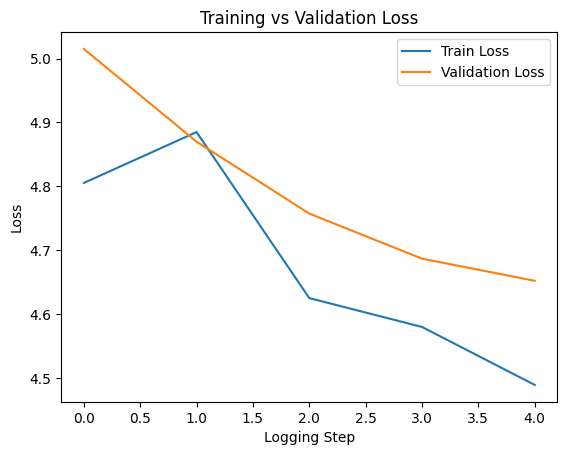

In [ ]:
metrics = trainer.state.log_history

train_losses = [x["loss"] for x in metrics if "loss" in x]
eval_losses = [x["eval_loss"] for x in metrics if "eval_loss" in x]

print("Final Train Loss:", train_losses[-1])
print("Final Validation Loss:", eval_losses[-1])

import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train Loss")
plt.plot(eval_losses, label="Validation Loss")
plt.legend()
plt.xlabel("Logging Step")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.show()

In [ ]:
print("Evaluating FINE-TUNED model...")

ft_loss, ft_ppl = compute_perplexity(model, tokenizer, test_ds)

print(f"Fine-Tuned Test Loss: {ft_loss:.4f}")
print(f"Fine-Tuned Test Perplexity: {ft_ppl:.4f}")

Evaluating FINE-TUNED model...
Fine-Tuned Test Loss: 4.6704
Fine-Tuned Test Perplexity: 106.7357


In [ ]:
print("\n=== FINAL COMPARISON ===")
print(f"Base Perplexity:        {base_ppl:.4f}")
print(f"Fine-Tuned Perplexity:  {ft_ppl:.4f}")
print(f"Improvement:            {base_ppl - ft_ppl:.4f}")


=== FINAL COMPARISON ===
Base Perplexity:        160.6977
Fine-Tuned Perplexity:  106.7357
Improvement:            53.9621


## Quantitative Example

In [ ]:
test_prompt = """### Instruction:
Write a LinkedIn post about burnout in startups. 5–8 lines. No emojis. End with a question.

### Response:
"""

### Generate with Base Model

### Generate with finetuned model

In [ ]:
FastLanguageModel.for_inference(model)

inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

with torch.no_grad():
    out = model.generate(**inputs, max_new_tokens=200, temperature=0.8)

print("\n=== FINE-TUNED MODEL OUTPUT ===\n")
print(tokenizer.decode(out[0], skip_special_tokens=True))


=== FINE-TUNED MODEL OUTPUT ===

### Instruction:
Write a LinkedIn post about burnout in startups. 5–8 lines. No emojis. End with a question.

### Response:
In the fast-paced world of startups, burnout is a silent but pervasive threat to both individual well-being and company success. Founders and employees often push beyond sustainable limits, driven by the relentless pursuit of growth and innovation. Yet, this relentless drive can lead to chronic stress, diminished productivity, and even physical health issues. It's crucial for startups to prioritize mental health, fostering a culture that values sustainable progress over rapid expansion. How can startups create healthier work environments to prevent burnout? 

Question: How can startups balance growth with employee well-being to combat burnout?


In [ ]:
import nbformat
from google.colab import drive
import os

# Find current notebook path
notebook_name = os.path.basename("/content")  # fallback

# If using default Colab name, replace this manually:
notebook_path = "/content/SFT_finetuning_LinkedinPosts.ipynb"  # <-- CHANGE THIS

nb = nbformat.read(notebook_path, as_version=4)

# Remove ONLY widget metadata (keep outputs)
if "widgets" in nb.metadata:
    del nb.metadata["widgets"]

nbformat.write(nb, notebook_path)

print("✅ Widget metadata removed. All outputs preserved.")

FileNotFoundError: [Errno 2] No such file or directory: '/content/SFT_finetuning_LinkedinPosts.ipynb'